In [1]:
print("Dasari Veera Raghavulu")
print("E23CSEU2320")

Dasari Veera Raghavulu
E23CSEU2320


In [2]:
!pip install -q kaggle

from google.colab import files
files.upload()   # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raghava44","key":"8fe4ea1f11ebca4a386c856ec6e1bb42"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/edges2shoes.tar.gz
!tar -xvf edges2shoes.tar.gz


Streaming output truncated to the last 5000 lines.
edges2shoes/train/46382_AB.jpg
edges2shoes/train/46383_AB.jpg
edges2shoes/train/46384_AB.jpg
edges2shoes/train/46385_AB.jpg
edges2shoes/train/46386_AB.jpg
edges2shoes/train/46387_AB.jpg
edges2shoes/train/46388_AB.jpg
edges2shoes/train/46389_AB.jpg
edges2shoes/train/4638_AB.jpg
edges2shoes/train/46390_AB.jpg
edges2shoes/train/46391_AB.jpg
edges2shoes/train/46392_AB.jpg
edges2shoes/train/449_AB.jpg
edges2shoes/train/44_AB.jpg
edges2shoes/train/45000_AB.jpg
edges2shoes/train/45001_AB.jpg
edges2shoes/train/45002_AB.jpg
edges2shoes/train/45003_AB.jpg
edges2shoes/train/45004_AB.jpg
edges2shoes/train/45005_AB.jpg
edges2shoes/train/45006_AB.jpg
edges2shoes/train/45007_AB.jpg
edges2shoes/train/45008_AB.jpg
edges2shoes/train/45009_AB.jpg
edges2shoes/train/4500_AB.jpg
edges2shoes/train/45010_AB.jpg
edges2shoes/train/45011_AB.jpg
edges2shoes/train/45012_AB.jpg
edges2shoes/train/45013_AB.jpg
edges2shoes/train/45687_AB.jpg
edges2shoes/train/45688_AB

In [6]:
!ls edges2shoes


train  val


In [7]:
import torch
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import glob

class Edges2ShoesDataset(Dataset):
    def __init__(self, root_dir):
        self.image_paths = sorted(glob.glob(os.path.join(root_dir, "*.jpg")))

        self.transform = transforms.Compose([
            transforms.Resize((256, 512)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5),
                                 (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        img = self.transform(img)

        # Split image into input and target
        input_img = img[:, :, :256]   # left half (edges)
        target_img = img[:, :, 256:]  # right half (real image)

        return input_img, target_img


In [8]:
train_dataset = Edges2ShoesDataset("edges2shoes/train")
val_dataset = Edges2ShoesDataset("edges2shoes/val")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print("Training Images:", len(train_dataset))
print("Validation Images:", len(val_dataset))


Training Images: 49825
Validation Images: 200


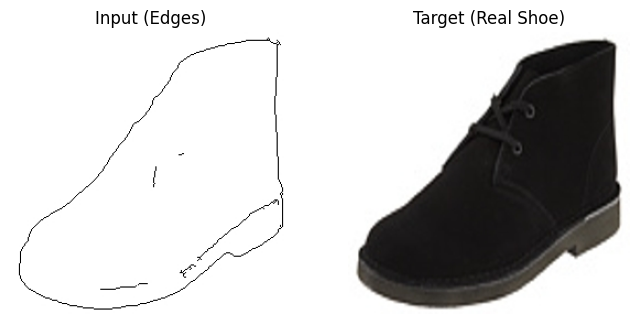

In [9]:
import matplotlib.pyplot as plt

input_img, target_img = train_dataset[0]

# Denormalize for display
def denorm(x):
    return x * 0.5 + 0.5

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(denorm(input_img).permute(1,2,0))
plt.title("Input (Edges)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(denorm(target_img).permute(1,2,0))
plt.title("Target (Real Shoe)")
plt.axis("off")

plt.show()


In [10]:
import torch
import torch.nn as nn

class UNetGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        # Downsampling
        self.down1 = self.down_block(3, 64, normalize=False)
        self.down2 = self.down_block(64, 128)
        self.down3 = self.down_block(128, 256)
        self.down4 = self.down_block(256, 512)

        # Upsampling
        self.up1 = self.up_block(512, 256)
        self.up2 = self.up_block(512, 128)
        self.up3 = self.up_block(256, 64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Tanh()
        )

    def down_block(self, in_c, out_c, normalize=True):
        layers = [nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.LeakyReLU(0.2))
        return nn.Sequential(*layers)

    def up_block(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        u1 = self.up1(d4)
        u1 = torch.cat([u1, d3], dim=1)

        u2 = self.up2(u1)
        u2 = torch.cat([u2, d2], dim=1)

        u3 = self.up3(u2)
        u3 = torch.cat([u3, d1], dim=1)

        return self.final(u3)


In [11]:
class PatchGAN(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(6, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 1, 4, 1, 1)
        )

    def forward(self, input_img, target_img):
        x = torch.cat([input_img, target_img], dim=1)
        return self.model(x)


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

G = UNetGenerator().to(device)
D = PatchGAN().to(device)

optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()

lambda_L1 = 100


In [ ]:
num_epochs = 1   # start small for testing

for epoch in range(num_epochs):
    for i, (input_img, target_img) in enumerate(train_loader):

        input_img = input_img.to(device)
        target_img = target_img.to(device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        fake_img = G(input_img)

        real_pred = D(input_img, target_img)
        fake_pred = D(input_img, fake_img.detach())

        real_loss = criterion_GAN(real_pred, torch.ones_like(real_pred))
        fake_loss = criterion_GAN(fake_pred, torch.zeros_like(fake_pred))

        d_loss = (real_loss + fake_loss) * 0.5
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        # Train Generator
        # ---------------------
        optimizer_G.zero_grad()

        fake_pred = D(input_img, fake_img)

        gan_loss = criterion_GAN(fake_pred, torch.ones_like(fake_pred))
        l1_loss = criterion_L1(fake_img, target_img)

        g_loss = gan_loss + lambda_L1 * l1_loss
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  D Loss: {d_loss.item():.4f}  G Loss: {g_loss.item():.4f}")


Epoch [1/5]  D Loss: 1.4952  G Loss: 13.3867
Epoch [2/5]  D Loss: 0.1621  G Loss: 37.9712
Epoch [3/5]  D Loss: 1.1213  G Loss: 14.8189
Epoch [4/5]  D Loss: 1.5513  G Loss: 34.2727


In [ ]:
G.eval()

input_img, target_img = val_dataset[0]
input_img = input_img.unsqueeze(0).to(device)

with torch.no_grad():
    fake_img = G(input_img)

def denorm(x):
    return x * 0.5 + 0.5

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(denorm(input_img[0]).cpu().permute(1,2,0))
plt.title("Input")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(denorm(target_img).permute(1,2,0))
plt.title("Real")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(denorm(fake_img[0]).cpu().permute(1,2,0))
plt.title("Generated")
plt.axis("off")

plt.show()
